In Part 3 we'll evaluate performance of our models using Score calculation described in part 1, using TimeSeriesSplit cross-validation. However, we'll use a new function, ['functions/get_score_3.py'](functions/get_score_3.py). 

This function will predict residuals ('emission_04') and then add to predictions Trend, Seasonality and Cycles_forecast, to predict 'emission'. Then it will calculate the Score, in the same wasy as in part 1.

Let's load the datasets:

In [118]:
%%time

import pandas as pd
import numpy as np


global_variables = pd.read_csv('global_variables.csv', index_col=0)
SEED = global_variables.loc[0, 'SEED']
N_SPLITS = global_variables.loc[0, 'N_SPLITS']

train_unprocessed = pd.read_csv('datasets/train.csv', index_col='ID_LAT_LON_YEAR_WEEK')
test_unprocessed = pd.read_csv('datasets/test.csv', index_col='ID_LAT_LON_YEAR_WEEK')
train_from_part_1 = pd.read_csv('new_datasets/train_from_part_1.csv', index_col='ID_LAT_LON_YEAR_WEEK')
test_from_part_1 = pd.read_csv('new_datasets/test_from_part_1.csv', index_col='ID_LAT_LON_YEAR_WEEK')
train_from_part_2 = pd.read_csv('new_datasets/train_from_part_2.csv', index_col='ID_LAT_LON_YEAR_WEEK')
cv_from_part_2 = pd.read_csv('new_datasets/cv_from_part_2.csv', index_col='ID_LAT_LON_YEAR_WEEK')
test_from_part_2 = pd.read_csv('new_datasets/test_from_part_2.csv', index_col='ID_LAT_LON_YEAR_WEEK')

top_three_values = train_from_part_1.loc[:, 'Location_enc'].drop_duplicates().sort_values(ascending = False).head(3)
top_three_locations = train_from_part_1.loc[train_from_part_1['Location_enc'].isin(top_three_values), 'Location'].drop_duplicates()


CPU times: total: 2.22 s
Wall time: 2.38 s


We'll create a DataFrame that won't be used in models training, but just for calculating the final prediction:

In [119]:
post_training_df = pd.concat([train_from_part_2, cv_from_part_2, test_from_part_2])[['Trend', 'Seasonality',
                                                                                     'Cycles_forecast', 'emission']]

Now, let's create 'train' and 'test' sets, that will contain all the variables we may use for our predictions, making sure we won't include variables that caclulate 'emission' from residuals, to avoid data leakage:

In [120]:
train = pd.concat([train_unprocessed.drop('emission', axis=1), 
                   pd.concat([train_from_part_2, cv_from_part_2])[['Location', 'WeekCount',
                                                                            'date', 'emission_04']]], axis=1)
train['date'] = pd.to_datetime(train['date'])
test = pd.concat([test_unprocessed, test_from_part_2[['Location', 'WeekCount', 'date']]], axis=1)
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

## 00. Baseline.

As a baseline, we'll fit LightGBM estimator to one feature, which will be just the column of 0's. We still should get quite a good Score (I remind you that lower is merrier), because predicted residuals will be transformed into 'emission' using features we calculated in Part 2:

In [121]:
%%time

study_number = '00'

scores_df = pd.DataFrame({'Comment': [], 'Train Score': [], 'Cross-val Score': [], 'Test RMSE': []})

train_selected = pd.DataFrame(index=train_unprocessed.index, columns=['dummy', 'emission_04'])
train_selected['dummy'] = 0
train_selected['emission_04'] = pd.concat([train_from_part_2, cv_from_part_2])['emission_04']
test_selected = pd.DataFrame(index=test_unprocessed.index, columns=['dummy'])
test_selected['dummy'] = 0


# Instantiate the estimator
# UNCOMMENT TO INSTALL LightGBM
#!pip install lightgbm
import lightgbm as lgb
model = lgb.LGBMRegressor(random_state=SEED, n_jobs=-1, n_estimators=10)

# Calculate scores
from functions.get_score_3 import get_score_3

train_score, cross_score, cross_scores_std, submission = get_score_3(global_variables, train_selected, test_selected, 
                                                                     post_training_df, model, scores_df,
                                                                  comment="Part 3 Baseline")

submission.to_csv('submissions/submission_3_' + study_number + '.csv', index=False)

CPU times: total: 2.08 s
Wall time: 242 ms


In [122]:
scores_df.loc[int(study_number), 'Test RMSE'] = 33.37721
scores_df

,Comment,Train Score,Cross-val Score,Test RMSE
0,Part 3 Baseline,27.134698,34.734972,33.37721


## 01. Location Median Target Encoding

Next, we'll recalculate our 'Location_enc' feature, same as Part 1, but with respect to residuals:

In [123]:
study_number = '01'

location_median = train.groupby('Location')['emission_04'].median()

train['Location_enc'] = train['Location'].map(location_median)
test['Location_enc'] = test['Location'].map(location_median)

feature_name = 'Location_enc'
for data in [train, test]:
    print(data[feature_name].info())
    print(data[feature_name].describe())
    print('Unique Values and their count:')
    print(data[feature_name].value_counts())

<class 'pandas.core.series.Series'>
Index: 79023 entries, ID_-0.510_29.290_2019_00 to ID_-3.299_30.301_2021_52
Series name: Location_enc
Non-Null Count  Dtype  
--------------  -----  
79023 non-null  float64
dtypes: float64(1)
memory usage: 1.2+ MB
None
count    79023.000000
mean         0.105686
std          0.651883
min         -1.012455
25%         -0.010697
50%          0.001573
75%          0.075346
max         10.587300
Name: Location_enc, dtype: float64
Unique Values and their count:
 0.000000e+00    3975
-9.374308e-12    2385
 1.776357e-15     477
 1.421085e-14     318
 1.348522e-02     159
                 ... 
-1.848602e-01     159
-1.069743e-02     159
 4.189234e-02     159
-9.089556e-02     159
 6.729004e-03     159
Name: Location_enc, Length: 456, dtype: int64
<class 'pandas.core.series.Series'>
Index: 24353 entries, ID_-0.510_29.290_2022_00 to ID_-3.299_30.301_2022_48
Series name: Location_enc
Non-Null Count  Dtype  
--------------  -----  
24353 non-null  float64
dtypes

Let's test:

In [124]:
%%time

selected_columns = ['Location_enc']

train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train['emission_04']], axis=1)
test_selected =  test[selected_columns]

#Calculate scores
train_score, cross_score, cross_scores_std, submission = get_score_3(global_variables, train_selected, test_selected, 
                                                                     post_training_df, model, scores_df,
                                                                  comment="Location_enc")

submission.to_csv('submissions/submission_3_' + study_number + '.csv', index=False)

CPU times: total: 2.56 s
Wall time: 296 ms


In [125]:
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan
scores_df

,Comment,Train Score,Cross-val Score,Test RMSE
0,Part 3 Baseline,27.134698,34.734972,33.37721
1,Location_enc,27.134793,34.734777,NaN


We see a small improvement.

## Week of the year Median Target Encoding

What if we do encoding on the 'week_no' feature? Potentially, it may catch some weekly common sesoanalities, if they exist.

In [126]:
study_number = '02'

week_no_median = train.groupby('week_no')['emission_04'].median()

train['week_no_enc'] = train['week_no'].map(week_no_median)
test['week_no_enc'] = test['week_no'].map(week_no_median)

feature_name = 'week_no_enc'
for data in [train, test]:
    print(data[feature_name].info())
    print(data[feature_name].describe())
    print('Unique Values and their count:')
    print(data[feature_name].value_counts())


<class 'pandas.core.series.Series'>
Index: 79023 entries, ID_-0.510_29.290_2019_00 to ID_-3.299_30.301_2021_52
Series name: week_no_enc
Non-Null Count  Dtype  
--------------  -----  
79023 non-null  float64
dtypes: float64(1)
memory usage: 3.2+ MB
None
count    7.902300e+04
mean    -1.471383e-02
std      7.813254e-01
min     -2.496314e+00
25%     -3.294547e-01
50%     -9.374308e-12
75%      1.292590e-01
max      3.210602e+00
Name: week_no_enc, dtype: float64
Unique Values and their count:
-4.524510e-01    1491
 2.127272e-02    1491
-1.466749e-01    1491
-6.457632e-01    1491
 7.229542e-01    1491
-4.026818e-01    1491
-8.937323e-01    1491
-4.635208e-01    1491
-6.366719e-03    1491
-5.562158e-01    1491
-2.100762e-01    1491
-1.647943e-03    1491
-5.405029e-01    1491
-6.907519e-04    1491
 5.364833e-02    1491
 6.275108e-01    1491
 1.392632e+00    1491
-2.496314e+00    1491
 4.048363e-02    1491
 1.514388e-01    1491
 3.510764e-01    1491
-7.327125e-02    1491
-9.374308e-12    1491

Let's test:

In [127]:
%%time

selected_columns.append('week_no_enc')

train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train['emission_04']], axis=1)
test_selected =  test[selected_columns]


#Calculate scores
train_score, cross_score, cross_scores_std, submission = get_score_3(global_variables, train_selected, test_selected, 
                                                                     post_training_df, model, scores_df,
                                                                  comment="+ week_no_enc")

submission.to_csv('submissions/submission_3_' + study_number + '.csv', index=False)

CPU times: total: 2.78 s
Wall time: 291 ms


In [128]:
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan
scores_df

,Comment,Train Score,Cross-val Score,Test RMSE
0,Part 3 Baseline,27.134698,34.734972,33.37721
1,Location_enc,27.134793,34.734777,NaN
2,+ week_no_enc,28.190695,35.117531,NaN


No, that didn't work, maybe, there is no common seasonality left across all Locations.

In [129]:
selected_columns.remove('week_no_enc')

train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train['emission_04']], axis=1)
test_selected =  test[selected_columns]

## 03. Most important features

Let's estimate what features are most important for calculating our residues:

In [130]:
%%time

study_number = '03'

## Train the model on the whole training set
model.fit(train.drop(['emission_04', 'Location', 'date'], axis=1), train['emission_04'])

feature_importances = pd.Series(data=model.feature_importances_, 
                                index=train.drop(['emission_04', 'Location', 'date'], axis=1).columns)

print('Sorted feature importances (first 40):')
feature_importances.sort_values(ascending=False).head(40)

Sorted feature importances (first 40):
CPU times: total: 2.33 s
Wall time: 324 ms


Location_enc                                               78
latitude                                                   41
longitude                                                  38
week_no_enc                                                38
Ozone_solar_zenith_angle                                   12
CarbonMonoxide_CO_column_number_density                    11
UvAerosolIndex_solar_zenith_angle                          10
WeekCount                                                   8
UvAerosolIndex_sensor_altitude                              7
Ozone_O3_column_number_density                              6
Cloud_surface_albedo                                        4
Formaldehyde_sensor_azimuth_angle                           4
UvAerosolIndex_solar_azimuth_angle                          4
NitrogenDioxide_stratospheric_NO2_column_number_density     3
Cloud_solar_zenith_angle                                    3
Cloud_cloud_optical_depth                                   3
Ozone_se

Few observations:

-) The same model used way more features in calculating residues, than in calculating 'emission' (see Part 1).
-) In combination with other features, 'week_no_enc' was useful for the model (although, it may still not pass the cross-validation testing)
-) Even though we have 'Location_enc', latitudes and longitudes are still important

Let's test a model based on the 3 most important features:

In [131]:
%%time

selected_columns = list(feature_importances.sort_values(ascending=False).index[:3])

print('Selected columns: {}'.format(selected_columns))
train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train['emission_04']], axis=1)
test_selected =  test[selected_columns]


#Calculate scores
train_score, cross_score, cross_scores_std, submission = get_score_3(global_variables, train_selected, test_selected, 
                                                                     post_training_df, model, scores_df,
                                                                  comment="1 + latit+longit")

submission.to_csv('submissions/submission_3_' + study_number + '.csv', index=False)

Selected columns: ['Location_enc', 'latitude', 'longitude']
CPU times: total: 3.08 s
Wall time: 298 ms


In [132]:
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan
scores_df

,Comment,Train Score,Cross-val Score,Test RMSE
0,Part 3 Baseline,27.134698,34.734972,33.37721
1,Location_enc,27.134793,34.734777,NaN
2,+ week_no_enc,28.190695,35.117531,NaN
3,1 + latit+longit,27.134847,34.734270,NaN


## 04. Geographical clustering

The importance of latitude and longitude suggest benefits of creating location clusters: groups of locations that situated nearby. We'll also account for the 'emissions_04' to make clusters depending on similar emissions.

First we'll create an elbow plot to detrmine an optimal number of clusters:

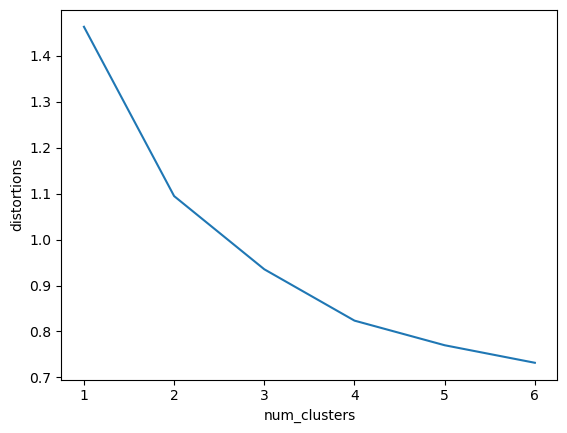

CPU times: total: 2.95 s
Wall time: 3.14 s


In [133]:
%%time

study_number = '04'

from sklearn.preprocessing import StandardScaler
from scipy.cluster.vq import kmeans, vq
import matplotlib.pyplot as plt
import seaborn as sns


# Create cluster data
cluster_data = train[['latitude', 'longitude', 'emission_04']]

# Normalize data
cluster_data = pd.DataFrame(StandardScaler().fit_transform(cluster_data), columns=['latitude', 'longitude', 'emission_04'],
                           index=cluster_data.index)

distortions = []
num_clusters = range(1, 7)

# Create a list of distortions from the kmeans function
for i in num_clusters:
    cluster_centers, distortion = kmeans(cluster_data, k_or_guess=i, seed=SEED)
    distortions.append(distortion)

# Create a DataFrame with two lists - num_clusters, distortions
elbow_plot = pd.DataFrame({'num_clusters': num_clusters, 'distortions': distortions})

# Creat a line plot of num_clusters and distortions
sns.lineplot(x='num_clusters', y='distortions', data = elbow_plot)
plt.xticks(num_clusters)
plt.show()

It seems that the optimal number of clusters is 2, but 4 can be also an option. Let's start with 2 clusters and look how they are situaded geographically:

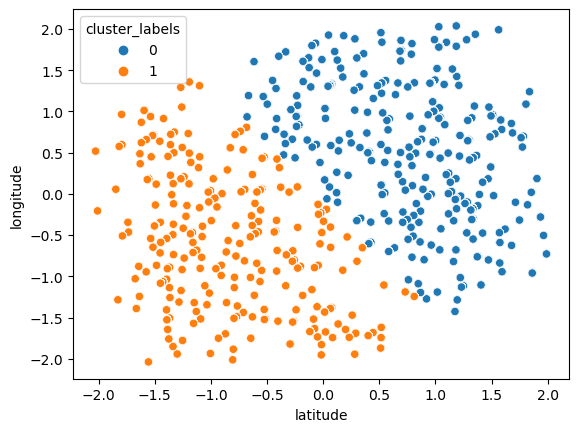

CPU times: total: 1.97 s
Wall time: 2.17 s


In [134]:
%%time

cluster_centers, distortion = kmeans(cluster_data, k_or_guess=2, seed=SEED)


# Assign cluster labels
cluster_data['cluster_labels'], _ = vq(cluster_data, cluster_centers)


# Create a scatter plot
sns.scatterplot(x='latitude', y='longitude', hue='cluster_labels', data=cluster_data)
plt.show()

Note, that even though we used scaled 'emission_04' in our clustering, our clusters have nice geographical borders. Now, let's test:

In [135]:
%%time

# Save the cluster labels into train and set
clusters = pd.concat([train['Location'], cluster_data['cluster_labels']], axis=1)
clusters = pd.pivot_table(clusters, values=['cluster_labels'], index=['Location'])
clusters = pd.Series(clusters['cluster_labels'])

train['Location_cluster_2'] = train['Location'].map(clusters)
test['Location_cluster_2'] = test['Location'].map(clusters)

selected_columns.append('Location_cluster_2')

print('Selected columns: {}'.format(selected_columns))
train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train['emission_04']], axis=1)
test_selected =  test[selected_columns]

#Calculate scores
train_score, cross_score, cross_scores_std, submission = get_score_3(global_variables, train_selected, test_selected, 
                                                                     post_training_df, model, scores_df,
                                                                  comment="+ Location_cluster_2")

submission.to_csv('submissions/submission_3_' + study_number + '.csv', index=False)

Selected columns: ['Location_enc', 'latitude', 'longitude', 'Location_cluster_2']
CPU times: total: 2.88 s
Wall time: 326 ms


In [136]:
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan
scores_df

,Comment,Train Score,Cross-val Score,Test RMSE
0,Part 3 Baseline,27.134698,34.734972,33.37721
1,Location_enc,27.134793,34.734777,NaN
2,+ week_no_enc,28.190695,35.117531,NaN
3,1 + latit+longit,27.134847,34.734270,NaN
4,+ Location_cluster_2,27.134847,34.734321,NaN


That didn't work.

## 05. Geographical clustering (4 clusters)

Let's try 4 clusters:

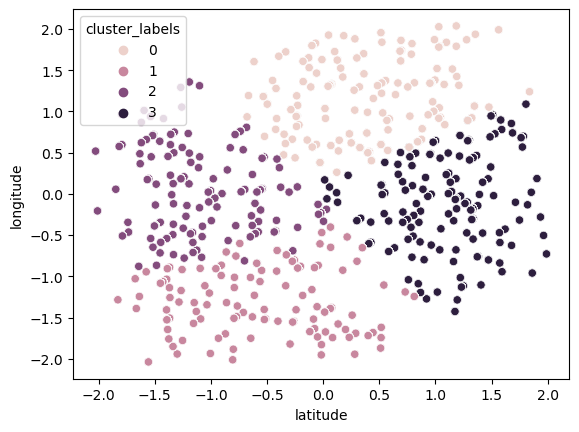

CPU times: total: 4.56 s
Wall time: 5.07 s


In [137]:
%%time

study_number = '05'

selected_columns.remove('Location_cluster_2')

cluster_centers, distortion = kmeans(cluster_data, k_or_guess=4, seed=SEED)


# Assign cluster labels
cluster_data['cluster_labels'], _ = vq(cluster_data, cluster_centers)


# Create a scatter plot
sns.scatterplot(x='latitude', y='longitude', hue='cluster_labels', data=cluster_data)
plt.show()

In [138]:
%%time

# Save the cluster labels into train and set
clusters = pd.concat([train['Location'], cluster_data['cluster_labels']], axis=1)
clusters = pd.pivot_table(clusters, values=['cluster_labels'], index=['Location'])
clusters = pd.Series(clusters['cluster_labels'])

train['Location_cluster_4'] = train['Location'].map(clusters)
test['Location_cluster_4'] = test['Location'].map(clusters)

selected_columns.append('Location_cluster_4')

print('Selected columns: {}'.format(selected_columns))
train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train['emission_04']], axis=1)
test_selected =  test[selected_columns]

#Calculate scores
train_score, cross_score, cross_scores_std, submission = get_score_3(global_variables, train_selected, test_selected, 
                                                                     post_training_df, model, scores_df,
                                                                  comment="3 + Location_cluster_4")

submission.to_csv('submissions/submission_3_' + study_number + '.csv', index=False)

Selected columns: ['Location_enc', 'latitude', 'longitude', 'Location_cluster_4']
CPU times: total: 3.12 s
Wall time: 349 ms


In [139]:
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan
scores_df

,Comment,Train Score,Cross-val Score,Test RMSE
0,Part 3 Baseline,27.134698,34.734972,33.37721
1,Location_enc,27.134793,34.734777,NaN
2,+ week_no_enc,28.190695,35.117531,NaN
3,1 + latit+longit,27.134847,34.734270,NaN
4,+ Location_cluster_2,27.134847,34.734321,NaN
5,3 + Location_cluster_4,27.134883,34.734470,NaN


That didn't work. I also tried to remove latitude and longitude, but it didn't work as well.

To be sure, let's expore how our new features affect feature importances:

In [140]:
## Train the model on the whole training set
model.fit(train.drop(['emission_04', 'Location', 'date'], axis=1), train['emission_04'])

feature_importances = pd.Series(data=model.feature_importances_, 
                                index=train.drop(['emission_04', 'Location', 'date'], axis=1).columns)

print('Sorted feature importances (first 40):')
feature_importances.sort_values(ascending=False).head(40)

Sorted feature importances (first 40):


Location_enc                                               76
week_no_enc                                                37
latitude                                                   32
longitude                                                  31
Location_cluster_4                                         27
Ozone_solar_zenith_angle                                   16
CarbonMonoxide_CO_column_number_density                    12
WeekCount                                                  10
UvAerosolIndex_solar_zenith_angle                           6
UvAerosolIndex_sensor_altitude                              5
Formaldehyde_sensor_azimuth_angle                           4
UvAerosolIndex_solar_azimuth_angle                          4
Cloud_surface_albedo                                        4
NitrogenDioxide_stratospheric_NO2_column_number_density     4
Cloud_cloud_optical_depth                                   3
Ozone_O3_effective_temperature                              2
UvAeroso

We see that this model treats Location_cluster_4 as an important feature, and introduction of clustering increased iportance of 'week_no_enc'.

We'll use this information in our strategy fo imputing missing values.

## 06. 15 most important features with missing values

First, we'll need to test our model on features with missing values. We'll take the 15 most important features to test our imputation strategies:

In [141]:
%%time

study_number = '06'

selected_columns = list(feature_importances.sort_values(ascending=False).index[:15])

print('Selected columns: {}'.format(selected_columns))
train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train['emission_04']], axis=1)
test_selected =  test[selected_columns]

#Calculate scores
train_score, cross_score, cross_scores_std, submission = get_score_3(global_variables, train_selected, test_selected, 
                                                                     post_training_df, model, scores_df,
                                                                  comment="15 features with NaNs")

submission.to_csv('submissions/submission_3_' + study_number + '.csv', index=False)

Selected columns: ['Location_enc', 'week_no_enc', 'latitude', 'longitude', 'Location_cluster_4', 'Ozone_solar_zenith_angle', 'CarbonMonoxide_CO_column_number_density', 'WeekCount', 'UvAerosolIndex_solar_zenith_angle', 'UvAerosolIndex_sensor_altitude', 'Formaldehyde_sensor_azimuth_angle', 'UvAerosolIndex_solar_azimuth_angle', 'Cloud_surface_albedo', 'NitrogenDioxide_stratospheric_NO2_column_number_density', 'Cloud_cloud_optical_depth']
CPU times: total: 5.03 s
Wall time: 543 ms


In [142]:
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan
scores_df

,Comment,Train Score,Cross-val Score,Test RMSE
0,Part 3 Baseline,27.134698,34.734972,33.37721
1,Location_enc,27.134793,34.734777,NaN
2,+ week_no_enc,28.190695,35.117531,NaN
3,1 + latit+longit,27.134847,34.734270,NaN
4,+ Location_cluster_2,27.134847,34.734321,NaN
5,3 + Location_cluster_4,27.134883,34.734470,NaN
6,15 features with NaNs,28.530193,35.665152,NaN


Our score is higher, than before, it seems that our simple estimator can't handle well such number of features. But we'll just use this Cross-val Score as a baseline for evaluating our imputation strategies.

## 07. Filling NaNs based on all features

First, we'll use KNNImputer to inmut missing values based on all 15 selected features:

In [143]:
%%time

study_number = '07'

from sklearn.impute import KNNImputer

# define imputer
imputer = KNNImputer(weights='distance')
# fit on the dataset
imputer.fit(train_selected.drop('emission_04', axis=1))
# transform the datasets
Xtrans = imputer.transform(train_selected.drop('emission_04', axis=1))
train_selected_filled = pd.DataFrame(Xtrans, index=train_selected.index)
train_selected_filled = pd.concat([train_selected_filled, train_selected['emission_04']], axis=1)
train_selected_filled.columns = train_selected.columns
Xtrans = imputer.transform(test_selected)
test_selected_filled = pd.DataFrame(Xtrans, index=test_selected.index, columns=test_selected.columns)


CPU times: total: 2min 31s
Wall time: 2min 1s


In [144]:
train_selected_filled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79023 entries, ID_-0.510_29.290_2019_00 to ID_-3.299_30.301_2021_52
Data columns (total 16 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Location_enc                                             79023 non-null  float64
 1   week_no_enc                                              79023 non-null  float64
 2   latitude                                                 79023 non-null  float64
 3   longitude                                                79023 non-null  float64
 4   Location_cluster_4                                       79023 non-null  float64
 5   Ozone_solar_zenith_angle                                 79023 non-null  float64
 6   CarbonMonoxide_CO_column_number_density                  79023 non-null  float64
 7   WeekCount                                                79023 non-null  fl

In [145]:
#Calculate scores
train_score, cross_score, cross_scores_std, submission = get_score_3(global_variables, train_selected_filled, 
                                                                     test_selected_filled, 
                                                                     post_training_df, model, scores_df,
                                                                  comment="kNN imputing")

submission.to_csv('submissions/submission_3_' + study_number + '.csv', index=False)

In [146]:
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan
scores_df

,Comment,Train Score,Cross-val Score,Test RMSE
0,Part 3 Baseline,27.134698,34.734972,33.37721
1,Location_enc,27.134793,34.734777,NaN
2,+ week_no_enc,28.190695,35.117531,NaN
3,1 + latit+longit,27.134847,34.734270,NaN
4,+ Location_cluster_2,27.134847,34.734321,NaN
5,3 + Location_cluster_4,27.134883,34.734470,NaN
6,15 features with NaNs,28.530193,35.665152,NaN
7,kNN imputing,28.521962,35.617772,NaN


This filling works better than NaNs.

## 07. Filling NaNs based on location and week of the year

Now we'll use 5 most important features in calculating distances. They contain information about location and weel of the year.

In [147]:
%%time

study_number = '06'

selected_columns_5 = list(feature_importances.sort_values(ascending=False).index[:5])
five_features_train = train[selected_columns_5]
five_features_test =  test[selected_columns_5]

# For each column with missing values
for column in list(train_selected.columns[train_selected.isna().any()]):
    
    # Create a DataFrame of a feature with missing values and 5 most important features
    df_to_fill_train = pd.concat([train[column], five_features_train], axis=1)
    df_to_fill_test = pd.concat([test[column], five_features_test], axis=1)
                                  
    # fit on the dataset
    imputer.fit(df_to_fill_train)
    # transform the datasets
    Xtrans = imputer.transform(df_to_fill_train)
    train_selected_filled[column] = Xtrans[:, 0]
    Xtrans = imputer.transform(df_to_fill_test)
    test_selected_filled[column] = Xtrans[:, 0]



CPU times: total: 3min 37s
Wall time: 2min 20s


In [148]:
train_selected_filled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79023 entries, ID_-0.510_29.290_2019_00 to ID_-3.299_30.301_2021_52
Data columns (total 16 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Location_enc                                             79023 non-null  float64
 1   week_no_enc                                              79023 non-null  float64
 2   latitude                                                 79023 non-null  float64
 3   longitude                                                79023 non-null  float64
 4   Location_cluster_4                                       79023 non-null  float64
 5   Ozone_solar_zenith_angle                                 79023 non-null  float64
 6   CarbonMonoxide_CO_column_number_density                  79023 non-null  float64
 7   WeekCount                                                79023 non-null  fl

In [149]:
test_selected_filled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24353 entries, ID_-0.510_29.290_2022_00 to ID_-3.299_30.301_2022_48
Data columns (total 15 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Location_enc                                             24353 non-null  float64
 1   week_no_enc                                              24353 non-null  float64
 2   latitude                                                 24353 non-null  float64
 3   longitude                                                24353 non-null  float64
 4   Location_cluster_4                                       24353 non-null  float64
 5   Ozone_solar_zenith_angle                                 24353 non-null  float64
 6   CarbonMonoxide_CO_column_number_density                  24353 non-null  float64
 7   WeekCount                                                24353 non-null  fl

In [150]:
#Calculate scores
train_score, cross_score, cross_scores_std, submission = get_score_3(global_variables, train_selected_filled,
                                                                     test_selected_filled, 
                                                                     post_training_df, model, scores_df,
                                                                  comment="kNN imputing based on 5")

submission.to_csv('submissions/submission_3_' + study_number + '.csv', index=False)

In [151]:
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan
scores_df

,Comment,Train Score,Cross-val Score,Test RMSE
0,Part 3 Baseline,27.134698,34.734972,33.37721
1,Location_enc,27.134793,34.734777,NaN
2,+ week_no_enc,28.190695,35.117531,NaN
3,1 + latit+longit,27.134847,34.734270,NaN
4,+ Location_cluster_2,27.134847,34.734321,NaN
5,3 + Location_cluster_4,27.134883,34.734470,NaN
6,15 features with NaNs,28.530193,35.665152,NaN
7,kNN imputing,28.521962,35.617772,NaN
8,kNN imputing based on 5,28.582089,35.618329,NaN


As we can see, kNN imputing based on all 15 features works better. Therefore, we'll use this strategy to fill all the missing values for all the features. This will be computantionally expensive, but we'll change the notebook soon afterwards to ['CO2 Emissions 4.ipynb'](CO2 Emissions 4.ipynb)

In [152]:
# fit on the dataset
imputer.fit(train.drop(['Location', 'date', 'emission_04'], axis=1))


KNNImputer(weights='distance')

In [ ]:
%%time

# transform the datasets
Xtrans = imputer.transform(train.drop(['Location', 'date', 'emission_04'], axis=1))


In [ ]:
train_filled = pd.DataFrame(Xtrans, index=train.index)
train_filled.columns = train.drop(['Location', 'date', 'emission_04'], axis=1).columns
train_filled = pd.concat([train_filled, train[['Location', 'date', 'emission_04']]], axis=1)

train_filled.head()

In [ ]:
%%time

Xtrans = imputer.transform(test.drop(['Location', 'date'], axis=1))


In [ ]:
test_filled = pd.DataFrame(Xtrans, index=test.index)
test_filled.columns = test.drop(['Location', 'date'], axis=1).columns
test_filled = pd.concat([test_filled, test[['Location', 'date']]], axis=1)


test_filled.head()

In [ ]:
print(train_filled.info())
print(test_filled.info())

In [ ]:
train_filled.to_csv('new_datasets/train_from_part_3.csv')
test_filled.to_csv('new_datasets/test_from_part_3.csv')
scores_df.to_csv('scores_df_3.csv')
df_to_fill_train.to_csv('new_datasets/df_to_fill_train.csv')
df_to_fill_test.to_csv('new_datasets/df_to_fill_test.csv')

In [ ]:
post_training_df.to_csv('new_datasets/post_training_df.csv')